In [ ]:
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize


# Cargar datos y normalizar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
usr_folder = r'/content/drive/MyDrive/Big Data/Datamining/Practica/2025_Datasets_Datamining' # Albert

In [ ]:
usr_folder = r'/content/drive/MyDrive/Master/Data Mining/Prácticas Data Mining/2025_Datasets_Datamining' # Wenjie#

In [ ]:
output_folder = usr_folder +  '/dataset_lite/Output'

In [ ]:
df = pd.read_csv(output_folder + "/features_upsampling.csv")
df.tail()

,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,zcr_9,zcr_10,...,delta2_mfcc_13_165,delta2_mfcc_13_166,delta2_mfcc_13_167,delta2_mfcc_13_168,delta2_mfcc_13_169,delta2_mfcc_13_170,delta2_mfcc_13_171,delta2_mfcc_13_172,delta2_mfcc_13_173,ship
4347,0.007044,0.013484,0.015041,0.013324,0.020044,0.019173,0.026135,0.028262,0.029992,0.032342,...,-0.081803,-0.367965,-0.395403,-0.326765,0.138960,0.390437,0.469228,0.406062,0.146983,Tug
4348,0.130323,0.211049,0.287656,0.293977,0.280268,0.238891,0.187044,0.131666,0.088767,0.055389,...,-0.443518,-0.392126,0.044809,0.478780,0.768694,0.594729,0.066847,-0.336104,-0.464424,Tug
4349,0.000488,0.000554,0.000753,0.000331,0.000331,0.000264,0.000132,0.000264,0.000397,0.000463,...,0.505860,0.273407,-0.059955,0.213428,0.517738,0.297803,0.218956,0.240117,-0.059945,Tug
4350,0.012884,0.020781,0.029078,0.028389,0.029189,0.027290,0.027590,0.029889,0.031454,0.046836,...,0.744246,0.734697,0.151671,0.096206,-0.104409,-0.237571,-0.149374,0.137438,0.143293,Tug
4351,0.051367,0.084218,0.114570,0.127825,0.132565,0.139569,0.150019,0.160084,0.159530,0.155813,...,-0.224293,-0.255093,-0.131576,0.140877,0.525694,0.670380,0.624501,-0.015984,-0.437976,Tug


In [ ]:
# Copia para comparar métodos
df_grouped = df.copy()
df_all_together = df.copy()

# NORMALIZACIÓN POR GRUPOS
scaler_zcr = StandardScaler()
scaler_rms = StandardScaler()
scaler_spectral = StandardScaler()
scaler_mfcc = StandardScaler()
scaler_delta1_mfcc = StandardScaler()
scaler_delta2_mfcc = StandardScaler()

df_grouped[[col for col in df_grouped.columns if 'zcr_' in col]] = scaler_zcr.fit_transform(df_grouped[[col for col in df_grouped.columns if 'zcr_' in col]])
df_grouped[[col for col in df_grouped.columns if 'rms_' in col]] = scaler_rms.fit_transform(df_grouped[[col for col in df_grouped.columns if 'rms_' in col]])
df_grouped[[col for col in df_grouped.columns if 'spectral_' in col]] = scaler_spectral.fit_transform(df_grouped[[col for col in df_grouped.columns if 'spectral_' in col]])
df_grouped[[col for col in df_grouped.columns if 'mfcc_' in col and 'delta' not in col]] = scaler_mfcc.fit_transform(df_grouped[[col for col in df_grouped.columns if 'mfcc_' in col and 'delta' not in col]])
df_grouped[[col for col in df_grouped.columns if 'delta1_mfcc_' in col]] = scaler_delta1_mfcc.fit_transform(df_grouped[[col for col in df_grouped.columns if 'delta1_mfcc_' in col]])
df_grouped[[col for col in df_grouped.columns if 'delta2_mfcc_' in col]] = scaler_delta2_mfcc.fit_transform(df_grouped[[col for col in df_grouped.columns if 'delta2_mfcc_' in col]])

# NORMALIZACIÓN TODO JUNTO
scaler = StandardScaler()
df_all_together[df_all_together.columns[df_all_together.columns != 'ship']] = scaler.fit_transform(df_all_together[df_all_together.columns[df_all_together.columns != 'ship']])

# Comparar estadísticas después de la normalización
print("Por grupos:")
print(df_grouped.describe())

print("\nTodo junto:")
print(df_all_together.describe())

Por grupos:
              zcr_1         zcr_2         zcr_3         zcr_4         zcr_5  \
count  4.352000e+03  4.352000e+03  4.352000e+03  4.352000e+03  4.352000e+03   
mean   1.044916e-16 -2.612289e-17 -7.183796e-17 -7.836868e-17 -5.877651e-17   
std    1.000115e+00  1.000115e+00  1.000115e+00  1.000115e+00  1.000115e+00   
min   -1.282099e+00 -1.302643e+00 -1.322502e+00 -1.317945e+00 -1.310733e+00   
25%   -8.171242e-01 -8.127539e-01 -8.076371e-01 -8.145204e-01 -8.274028e-01   
50%   -1.656271e-01 -1.813531e-01 -1.624593e-01 -1.615663e-01 -1.674392e-01   
75%    6.407164e-01  6.490641e-01  6.606580e-01  6.597857e-01  6.588064e-01   
max    4.519893e+00  4.614634e+00  4.913080e+00  5.139474e+00  5.145512e+00   

              zcr_6         zcr_7         zcr_8         zcr_9        zcr_10  \
count  4.352000e+03  4.352000e+03  4.352000e+03  4.352000e+03  4.352000e+03   
mean   1.632681e-16  6.530724e-17  1.959217e-17  1.893910e-16 -7.183796e-17   
std    1.000115e+00  1.000115e+00  1.00

In [ ]:
df.tail()

,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,zcr_9,zcr_10,...,delta2_mfcc_13_165,delta2_mfcc_13_166,delta2_mfcc_13_167,delta2_mfcc_13_168,delta2_mfcc_13_169,delta2_mfcc_13_170,delta2_mfcc_13_171,delta2_mfcc_13_172,delta2_mfcc_13_173,ship
4347,-1.018049,-0.959351,-1.028803,-1.056506,-0.916347,-0.930486,-0.787852,-0.742924,-0.701038,-0.650272,...,-0.138966,-0.797447,-0.900029,-0.837832,0.153712,0.675301,1.069333,1.319028,0.657950,Tug
4348,3.602960,4.070491,4.294469,4.450277,4.203863,3.420069,2.391356,1.304349,0.456670,-0.197444,...,-1.013561,-0.855850,0.161842,1.123285,1.594228,1.133927,0.002266,-1.173160,-1.526522,Tug
4349,-1.263796,-1.288528,-1.307803,-1.311459,-1.304228,-1.304894,-1.301601,-1.297227,-1.283995,-1.276628,...,1.281951,0.752906,-0.090868,0.477280,1.020166,0.467341,0.405641,0.761787,-0.081375,Tug
4350,-0.799166,-0.773583,-0.754712,-0.760907,-0.736403,-0.769775,-0.759102,-0.710705,-0.672252,-0.365477,...,1.858346,1.867957,0.419612,0.191899,-0.402992,-0.734544,-0.571129,0.416991,0.644764,Tug
4351,0.643343,0.841491,0.914671,1.190155,1.297633,1.453433,1.659830,1.866974,1.850530,1.775699,...,-0.483494,-0.524607,-0.263631,0.300652,1.038365,1.303758,1.481100,-0.098198,-1.432027,Tug


In [ ]:
df.describe()

,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,zcr_9,zcr_10,...,delta2_mfcc_13_164,delta2_mfcc_13_165,delta2_mfcc_13_166,delta2_mfcc_13_167,delta2_mfcc_13_168,delta2_mfcc_13_169,delta2_mfcc_13_170,delta2_mfcc_13_171,delta2_mfcc_13_172,delta2_mfcc_13_173
count,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,...,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4352.000000,4.352000e+03,4.352000e+03,4.352000e+03
mean,1.044916e-16,-2.612289e-17,-7.183796e-17,-7.836868e-17,-5.877651e-17,1.632681e-16,6.530724e-17,1.959217e-17,1.893910e-16,-7.183796e-17,...,-1.877583e-17,-6.530724e-18,2.285753e-17,-1.959217e-17,-2.000034e-17,1.959217e-17,0.000000,6.530724e-18,6.530724e-18,-1.959217e-17
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,...,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115,1.000115e+00,1.000115e+00,1.000115e+00
min,-1.282099e+00,-1.302643e+00,-1.322502e+00,-1.317945e+00,-1.310733e+00,-1.310130e+00,-1.304213e+00,-1.302463e+00,-1.291808e+00,-1.285720e+00,...,-4.379236e+00,-4.721571e+00,-3.905850e+00,-4.671255e+00,-3.997434e+00,-4.382084e+00,-4.596448,-4.277717e+00,-4.625670e+00,-3.271518e+00
25%,-8.171242e-01,-8.127539e-01,-8.076371e-01,-8.145204e-01,-8.274028e-01,-8.267162e-01,-8.132553e-01,-8.213361e-01,-8.269560e-01,-8.243608e-01,...,-6.390909e-01,-6.291931e-01,-6.362988e-01,-6.370951e-01,-6.506696e-01,-6.812382e-01,-0.667362,-6.569089e-01,-6.481964e-01,-6.610326e-01
50%,-1.656271e-01,-1.813531e-01,-1.624593e-01,-1.615663e-01,-1.674392e-01,-1.596052e-01,-1.754717e-01,-1.617217e-01,-1.665147e-01,-1.728439e-01,...,1.494416e-02,6.081330e-03,1.031161e-02,-5.484678e-04,5.132162e-03,1.628074e-02,0.009758,3.554154e-02,1.444040e-02,-4.496387e-03
75%,6.407164e-01,6.490641e-01,6.606580e-01,6.597857e-01,6.588064e-01,6.353773e-01,6.445544e-01,6.503311e-01,6.412778e-01,6.425848e-01,...,6.633855e-01,6.557318e-01,6.479688e-01,6.363498e-01,6.724233e-01,6.633167e-01,0.675328,6.673385e-01,6.639465e-01,6.458696e-01
max,4.519893e+00,4.614634e+00,4.913080e+00,5.139474e+00,5.145512e+00,5.302970e+00,4.773627e+00,4.845937e+00,4.709758e+00,4.739162e+00,...,4.135582e+00,4.048683e+00,4.458320e+00,4.329742e+00,3.516515e+00,4.238942e+00,4.296899,4.060629e+00,3.717187e+00,4.947047e+00


# Separar los datos

In [ ]:
df.tail(1)

,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,zcr_9,zcr_10,...,delta2_mfcc_13_165,delta2_mfcc_13_166,delta2_mfcc_13_167,delta2_mfcc_13_168,delta2_mfcc_13_169,delta2_mfcc_13_170,delta2_mfcc_13_171,delta2_mfcc_13_172,delta2_mfcc_13_173,ship
4351,0.643343,0.841491,0.914671,1.190155,1.297633,1.453433,1.65983,1.866974,1.85053,1.775699,...,-0.483494,-0.524607,-0.263631,0.300652,1.038365,1.303758,1.4811,-0.098198,-1.432027,Tug


In [ ]:
## Separación el dataframe según las características "X" y el target "y".
X = df.drop(columns=["ship"]) # Se quita el target y las caracerísticas que no se tienen que analizar

# Convertir los datos de X de string a float


# El target es adivinar el barco.
y = df["ship"]

# Codificar etiquetas categóricas a enteros
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convierte ["barco1", "barco2", ...] a [0,1,2,3]

# División estratificada para mantener la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23, stratify=y)

# Verificar la proporción de clases en train y test
print("Proporción en train:")
print(np.bincount(y_train) / len(y_train))
print("Total ejemplos en train:", len(y_train))

print("Proporción en test:")
print(np.bincount(y_test) / len(y_test))
print("Total ejemplos en test:", len(y_test))

Proporción en train:
[0.25016415 0.25016415 0.24983585 0.24983585]
Total ejemplos en train: 3046
Proporción en test:
[0.24961715 0.24961715 0.25038285 0.25038285]
Total ejemplos en test: 1306


# Entrenamiento

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
# Reestructurar X para CNN (num_samples, 44, 173)
X_train = X_train.to_numpy().reshape(len(X_train), 44, 173)
X_test = X_test.to_numpy().reshape(len(X_test), 44, 173)

# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Crear DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train) # Genera un dataset de train con labal [0...4]
test_dataset = TensorDataset(X_test, y_test) # Genera un dataset de test con labal [0...4]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Parámetros del dataset
n_features = 44   # 1 ZCR, 1 RMS, 3 SPECTRAL, 13 MFCC, , 13 DETLAS1 DE MFCC y 13 delta2 de MFCC
time_steps = 173  # Número de frames temporales por feature
num_classes = 4  # Cambia según tus clases de animales

# Definir la CNN 1D
class AudioCNN(nn.Module):
    def __init__(self, n_features, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # Reduce time_steps a la mitad
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 43, 256)  # Ajustado a time_steps=173
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (batch, 64, 86)
        x = self.pool(self.relu(self.conv2(x)))  # (batch, 128, 43)
        x = torch.flatten(x, start_dim=1)       # (batch, 128*43)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Crear modelo
model = AudioCNN(n_features=44, num_classes=num_classes).to(device)

# Resumen del modelo
print(model)

AudioCNN(
  (conv1): Conv1d(44, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=5504, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [ ]:
import torch.optim as optim

#Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
iteraciones = 10

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/100, Loss: 0.2320
Epoch 2/100, Loss: 0.2085
Epoch 3/100, Loss: 0.1821
Epoch 4/100, Loss: 0.1755
Epoch 5/100, Loss: 0.1405
Epoch 6/100, Loss: 0.1275
Epoch 7/100, Loss: 0.1087
Epoch 8/100, Loss: 0.1043
Epoch 9/100, Loss: 0.0896
Epoch 10/100, Loss: 0.0706
Epoch 11/100, Loss: 0.0568
Epoch 12/100, Loss: 0.0524
Epoch 13/100, Loss: 0.0452
Epoch 14/100, Loss: 0.0381
Epoch 15/100, Loss: 0.0343
Epoch 16/100, Loss: 0.0307
Epoch 17/100, Loss: 0.0277
Epoch 18/100, Loss: 0.0251
Epoch 19/100, Loss: 0.0224
Epoch 20/100, Loss: 0.0205
Epoch 21/100, Loss: 0.0197
Epoch 22/100, Loss: 0.0166
Epoch 23/100, Loss: 0.0159
Epoch 24/100, Loss: 0.0153
Epoch 25/100, Loss: 0.0133
Epoch 26/100, Loss: 0.0122
Epoch 27/100, Loss: 0.0120
Epoch 28/100, Loss: 0.0108
Epoch 29/100, Loss: 0.0103
Epoch 30/100, Loss: 0.0099
Epoch 31/100, Loss: 0.0092
Epoch 32/100, Loss: 0.0088
Epoch 33/100, Loss: 0.0082
Epoch 34/100, Loss: 0.0078
Epoch 35/100, Loss: 0.0074
Epoch 36/100, Loss: 0.0071
Epoch 37/100, Loss: 0.0069
Epoch 38/1

# Resultados

In [ ]:
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)  # Predicción final
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Probabilidades

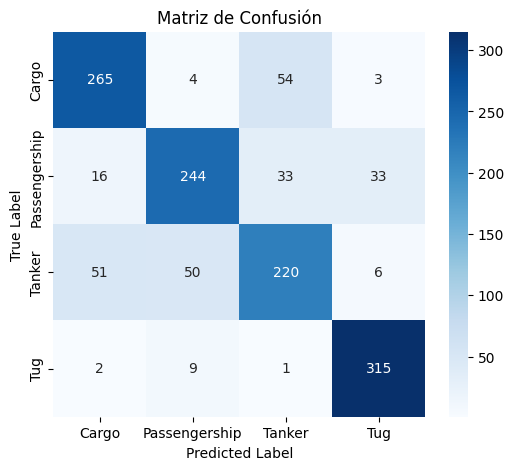

In [ ]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

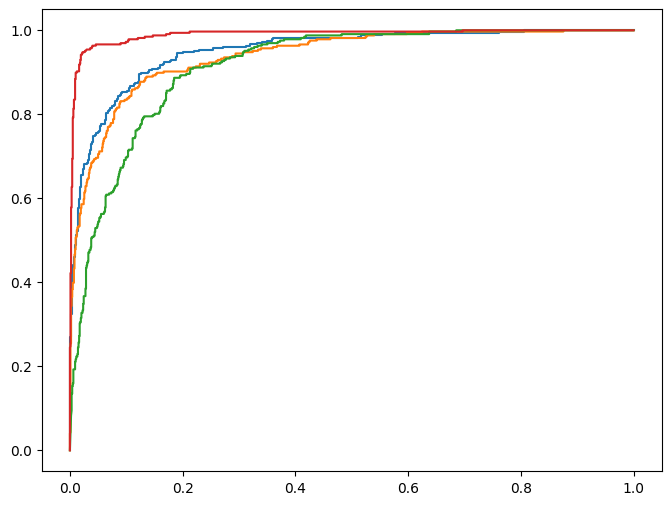

In [ ]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])  # Para 4 clases

plt.figure(figsize=(8, 6))

for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])  # FPR, TPR
    auc_score = roc_auc_score(y_true_bin[:, i], np.array(y_scores)[:, i])  # AUC

    plt.plot(fpr, tpr, label=f'Clase: {label} (AUC = {auc_score:.2f})')  # Etiqueta


In [ ]:
print("Reporte de clasificación:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Reporte de clasificación:
                precision    recall  f1-score   support

        Cargo       0.79      0.81      0.80       326
Passengership       0.79      0.75      0.77       326
       Tanker       0.71      0.67      0.69       327
          Tug       0.88      0.96      0.92       327

     accuracy                           0.80      1306
    macro avg       0.80      0.80      0.80      1306
 weighted avg       0.80      0.80      0.80      1306



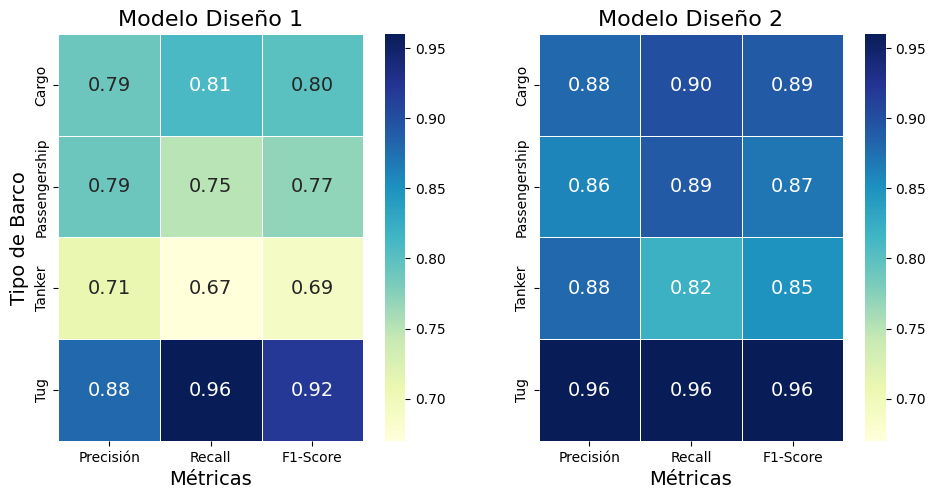

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Datos organizados en matrices separadas para cada modelo
data_modelo_1 = np.array([
    [0.79, 0.81, 0.80],
    [0.79, 0.75, 0.77],
    [0.71, 0.67, 0.69],
    [0.88, 0.96, 0.92]
])

data_modelo_2 = np.array([
    [0.88, 0.90, 0.89],
    [0.86, 0.89, 0.87],
    [0.88, 0.82, 0.85],
    [0.96, 0.96, 0.96]
])

# Obtener valores mínimo y máximo de ambas matrices para normalizar la escala de color
vmin = min(data_modelo_1.min(), data_modelo_2.min())
vmax = max(data_modelo_1.max(), data_modelo_2.max())

# Etiquetas de columnas y filas
metricas = ['Precisión', 'Recall', 'F1-Score']
barcos = ['Cargo', 'Passengership', 'Tanker', 'Tug']

# Crear subplots para los dos heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Se reduce el tamaño del gráfico

# Parámetros para mejorar la visualización
heatmap_params = {
    "annot": True,         # Mostrar valores en celdas
    "cmap": "YlGnBu",      # Esquema de colores
    "fmt": ".2f",          # Formato de los valores
    "xticklabels": metricas,
    "yticklabels": barcos,
    "annot_kws": {"size": 14},  # Tamaño de los números en las celdas
    "linewidths": 0.5,     # Separación entre celdas
    "square": True,         # Mantener celdas cuadradas
    "vmin": vmin,          # Fijar el valor mínimo en la escala de color
    "vmax": vmax           # Fijar el valor máximo en la escala de color
}

# Heatmap para Modelo Diseño 1
sns.heatmap(data_modelo_1, ax=axes[0], **heatmap_params)
axes[0].set_title("Modelo Diseño 1", fontsize=16)
axes[0].set_xlabel("Métricas", fontsize=14)
axes[0].set_ylabel("Tipo de Barco", fontsize=14)

# Heatmap para Modelo Diseño 2
sns.heatmap(data_modelo_2, ax=axes[1], **heatmap_params)
axes[1].set_title("Modelo Diseño 2", fontsize=16)
axes[1].set_xlabel("Métricas", fontsize=14)
axes[1].set_ylabel("")

# Ajustar diseño
plt.tight_layout()
plt.show()

# Heatmap para Modelo Diseño 1
sns.heatmap(data_modelo_1, ax=axes[0], **heatmap_params)
axes[0].set_title("Modelo Diseño 1", fontsize=16)
axes[0].set_xlabel("Métricas", fontsize=14)
axes[0].set_ylabel("Tipo de Barco", fontsize=14)

# Heatmap para Modelo Diseño 2
sns.heatmap(data_modelo_2, ax=axes[1], **heatmap_params)
axes[1].set_title("Modelo Diseño 2", fontsize=16)
axes[1].set_xlabel("Métricas", fontsize=14)
axes[1].set_ylabel("")

# Ajustar diseño
plt.tight_layout()
plt.show()
